# INM701: Random Forests (Part 1, Original Data)

We use scikit-learn to train and test a random forest model on a dataset of proteins and their secondary structures.

This notebook is specifically for the original data without any oversampling. The validation phase is done for both the Entropy and Gini criteria.

The work presented here is part of the coursework of the INM701 module at City, University of London. The Github repository can be found [here](https://github.com/yasirbarlas/City-INM701).

### Import Libraries

In [1]:
# Import Relevant Libraries
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# Ignore warnings (making the work easier to read)
import warnings
warnings.filterwarnings("ignore")

### Import Dataset

Refer to the 'eda-data-processing.ipynb' workbook for more detail on how this dataset was created.

In [2]:
# Create a variable for the path to the directory containing the dataset (and where to work)
path = "/kaggle/input/protein-sequences-16-100"

# Create a variable containing the full path of the dataset
dataset = os.path.join(path, "prot-seq-filtered.csv")

# Create a Pandas DataFrame of the dataset (which is a .csv file)
df = pd.read_csv(dataset, delimiter = ",")

df

,pdb_id,chain_code,seq,sst8,sst3,len
0,1BXL,B,GQVGRQLAIIGDDINR,CCTTHHHHHHHHHTCC,CCCCHHHHHHHHHCCC,16
1,1D9K,P,GNSHRGAIEWEGIESG,CCEECCCCCCCCCCCC,CCEECCCCCCCCCCCC,16
2,1DPU,B,RIQRNKAAALLRLAAR,CCSSHHHHHHHHHHCC,CCCCHHHHHHHHHHCC,16
3,1DXP,C,KGSVVIVGRIILSGRK,CCCBEEEEEEEECCCC,CCCEEEEEEEEECCCC,16
4,1EJH,E,KQYDREFLLDFQFMPA,CCCCHHHHHTTSCCCC,CCCCHHHHHCCCCCCC,16
...,...,...,...,...,...,...
15267,6UUJ,A,GAMVPEGLAAASAAVEALTARLAAAHASAAPVITAVVPPAADPVSL...,CCCCCSTTHHHHHHHHHHHHHHHHHHHHSHHHHHSCCCSSSSHHHH...,CCCCCCCCHHHHHHHHHHHHHHHHHHHHCHHHHHCCCCCCCCHHHH...,100
15268,6V7M,A,MKVLWAALLVTFLAGCQAKVEQAVETEPEPELRQQTEWQSGQRWEL...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCHHHH...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCHHHH...,100
15269,6VQX,A,MKVPAFFAANILTIEQIIEAINNDGSAMTSAPEIAGYYAWDAATDA...,CCCCSSTTSSCCCHHHHHHHHHTTSCTTSCHHHHHHHHHHHHHHHS...,CCCCCCCCCCCCCHHHHHHHHHCCCCCCCCHHHHHHHHHHHHHHHC...,100
15270,6XVF,F,RWLEGIRKWYYNAAGFNKLGLMRDDTIHENDDVKEAIRRLPENLYN...,CCTHHHHHHHHHHHCGGGGTCCGGGSBCCCHHHHHHHHTSCHHHHH...,CCCHHHHHHHHHHHCHHHHCCCHHHCECCCHHHHHHHHCCCHHHHH...,100


### Set Random Seed and $k$-mer Size

We choose a seed for reproducibility and a sensible $k$-mer size.

In [3]:
# k-mer size and seed choice

kmer_size = 3
randomer = 50

# Random Seed
random.seed(randomer)
np.random.seed(randomer)

### Generate $k$-mers

We convert our protein sequences in to $k$-mers, making the problem less computationally expensive. The choice of $k$ affects the performance of the model, with higher $k$ likely leading to less accurate models. This accuracy can vary based on much larger datasets, and with longer protein sequences.

For example, the 3-mers for "GQVGRQ" are:

GQV, QVG, VGR, GRQ

In [4]:
# Define k-mer function (n-gram)
def kmers(seq, k = kmer_size):
    return ([seq[i:i + k] for i in range(len(seq) - k + 1)])

# Apply the k-mer function to the amino acid sequences
df["kmers"] = df["seq"].apply(kmers)

# Find the maximum length of the sequences (we know from previously processing our dataset that it is 100)
maxlen = max(df["len"])
print("Maximum Protein Length:", maxlen)

df.head()

Maximum Protein Length: 100


,pdb_id,chain_code,seq,sst8,sst3,len,kmers
0,1BXL,B,GQVGRQLAIIGDDINR,CCTTHHHHHHHHHTCC,CCCCHHHHHHHHHCCC,16,"[GQV, QVG, VGR, GRQ, RQL, QLA, LAI, AII, IIG, ..."
1,1D9K,P,GNSHRGAIEWEGIESG,CCEECCCCCCCCCCCC,CCEECCCCCCCCCCCC,16,"[GNS, NSH, SHR, HRG, RGA, GAI, AIE, IEW, EWE, ..."
2,1DPU,B,RIQRNKAAALLRLAAR,CCSSHHHHHHHHHHCC,CCCCHHHHHHHHHHCC,16,"[RIQ, IQR, QRN, RNK, NKA, KAA, AAA, AAL, ALL, ..."
3,1DXP,C,KGSVVIVGRIILSGRK,CCCBEEEEEEEECCCC,CCCEEEEEEEEECCCC,16,"[KGS, GSV, SVV, VVI, VIV, IVG, VGR, GRI, RII, ..."
4,1EJH,E,KQYDREFLLDFQFMPA,CCCCHHHHHTTSCCCC,CCCCHHHHHCCCCCCC,16,"[KQY, QYD, YDR, DRE, REF, EFL, FLL, LLD, LDF, ..."


### Pre-processing and Padding

We use the Tokenizer class to transform our protein sequences and secondary structures into sequences of integers, where each integer is an index of a token in a dictionary. A dictionary is made for our 3-mers, and another dictionary is made for our secondary structures. Padding is performed to make the length of each sequence equal.

In [5]:
%%time

# We will use functions from Keras to pre-process our data to be used in the model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

# Create Tokenizer class for protein sequences, without making them lowercase
tok_x = Tokenizer(lower = False)
# Fit Tokenizer on protein sequences (k-mers)
tok_x.fit_on_texts(df["kmers"].values)
# Convert protein sequences into sequence of integers and pad where necessary
X = tok_x.texts_to_sequences(df["kmers"].values)
X = sequence.pad_sequences(X, maxlen = maxlen, padding = "post")

# Create Tokenizer class for secondary sequences, and treat every character (element) as a token
tok_y = Tokenizer(char_level = True)
# Fit Tokenizer on secondary structures
tok_y.fit_on_texts(df["sst3"].values)
# Convert secondary structures into sequence of integers and pad where necessary
y = tok_y.texts_to_sequences(df["sst3"].values)
y = sequence.pad_sequences(y, maxlen = maxlen, padding = "post")

X.shape, y.shape

CPU times: user 11.7 s, sys: 1.5 s, total: 13.2 s
Wall time: 17.2 s


((15272, 100), (15272, 100))

### Training, Validation and Test Split

We split our dataset into training, validation and test sets, where the training set is used to train the model. The validation set is used to choose a sensible model after it has been trained. The test set is used to test the performance of our final candidate model.

In [6]:
from sklearn.model_selection import train_test_split

# Split the data into training, validation and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size = 3/4, test_size = 1/4, random_state = randomer)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size = 1/3, test_size = 2/3, random_state = randomer)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((11454, 100),
 (11454, 100),
 (1272, 100),
 (1272, 100),
 (2546, 100),
 (2546, 100))

In [7]:
X_train[0], y_train[0]

(array([3272, 2093, 4483,  695,  203, 1554, 2110, 1956, 2856, 3513, 2841,
        2369, 1917, 3529, 1159,  110, 1527,  943, 3428, 4868, 4080, 6729,
        6249, 6991, 5684, 3603, 2648, 2493, 1682,  621, 1677, 1171, 2116,
         692, 1320, 3613, 4117, 4087, 1683, 4427, 2159, 2269, 3387, 2341,
        1270,  121,  365,  161, 2364, 2950, 4291, 5756, 4993, 4479, 3168,
        3306, 4084, 5154,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0], dtype=int32),
 array([1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3,
        3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0

In [8]:
from sklearn.metrics import classification_report

# Simple way to find out how many instances there are of each class
report1 = classification_report(y_train.flatten(), y_train.flatten(), output_dict = True)

print("Without Oversampling:")
for i in ["0","1","2","3"]:
    print("Number in Class", i, ":", report1[i]["support"], ",", report1[i]["support"] * 100 / report1["weighted avg"]["support"], "%")

Without Oversampling:
Number in Class 0 : 408388 , 35.65461847389558 %
Number in Class 1 : 366060 , 31.959140911471973 %
Number in Class 2 : 239124 , 20.876898899947616 %
Number in Class 3 : 131828 , 11.509341714684826 %


In [9]:
from collections import defaultdict

# Function to visualise distribution of SST-3/SST-8 (taken from EDA workbook, adapted to arrays)
def sst_visualise(array, ss_types, labels, ss_colours, title):
    ss_counts = defaultdict(lambda: 0)

    for row in array:
        for element in row:
            ss_counts[element] += 1

    plt.bar(range(len(ss_types)), height = [ss_counts[ss] for ss in ss_types], tick_label = labels, edgecolor = "black", width = 0.75, zorder = 3, color = ss_colours)
    plt.title(title)
    plt.xlabel("Element")
    plt.ylabel("Frequency")
    plt.show()

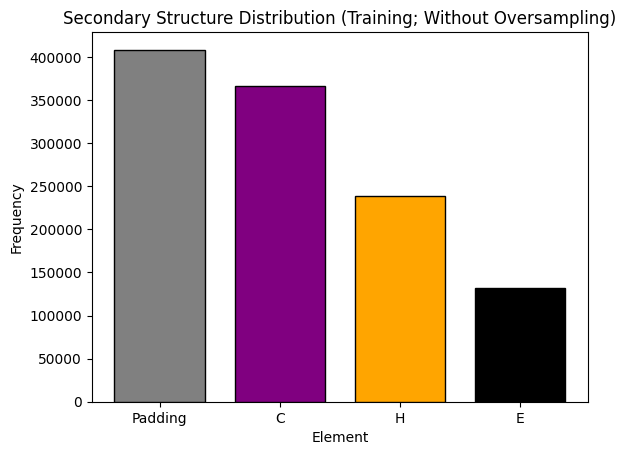

In [10]:
# Define elements for SST-3 and SST-8, and custom colours
ss_types = list(set(np.ravel(y_train)))
labels = ["Padding", "C", "H", "E"]
ss_colours = ["grey", "purple", "orange", "black"]

# Plot for training set distribution before oversampling
sst_visualise(y_train, ss_types, labels, ss_colours, "Secondary Structure Distribution (Training; Without Oversampling)")

### Import Classifier and Define Q3 Accuracy Metric

We are interested in using random forests for multi-output classification, so we import the relevant functions from scikit-learn. Q3 accuracy is an important metric for assessing the accuracy of our models, as it excludes the padding class in its calculations (it is otherwise equivalent to 'accuracy_score' from scikit-learn).

In [11]:
# Import MultiOutputClassifier and RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

# Create Q3 function using NumPy (accuracy of those other than zero, which is the padding)
def q3_acc_numpy(y_true, y_pred):
    mask = y_true > 0
    q3 = np.equal(np.extract(mask, y_true), np.extract(mask, y_pred)).astype(float)
    return np.sum(q3) / q3.shape[0]

### Investigate Suitable Number of Trees

We want to maximise the Q3 accuracy. It is difficult to test large numbers of trees, whilst trying to minimise the computational expense. A sensible range for the number of trees is chosen as [1, 60].

We test the performance of both the Entropy and Gini criteria to determine which of these provides better results.

#### Without Oversampling

[0.5326931589042443, 0.5653617272414302, 0.5813947769635568, 0.5877268479811144, 0.6030467712585452, 0.6043623665961737, 0.6111370678207839, 0.6154281217724881, 0.6188216200265578, 0.6197560615747799, 0.6241823636453057, 0.6259651797570452, 0.6294570402793488, 0.6322357743569567, 0.634473515959278, 0.634989917867506, 0.6377440613780554, 0.6371661830521812, 0.6394162199380318, 0.6392809718192102, 0.6409408350956574, 0.6418260955097624, 0.643092509713274, 0.6437564550238528, 0.6445187626026656, 0.6459081296414695, 0.646190921162642, 0.6472852013967442, 0.6486745684355482, 0.6483917769143757, 0.6486253873014312, 0.6492524467614224, 0.6493262184625977, 0.649547533566124, 0.65058033738258, 0.6506418138002262, 0.6518098657355038, 0.6520065902719717, 0.6522893817931441, 0.6532730044754832, 0.653518910146068, 0.6538631780848866, 0.6534451384448925, 0.6547361432154626, 0.65429351300841, 0.65429351300841, 0.6547730290660503, 0.6547238479319333, 0.6555476319283923, 0.6554369743766292, 0.655424679

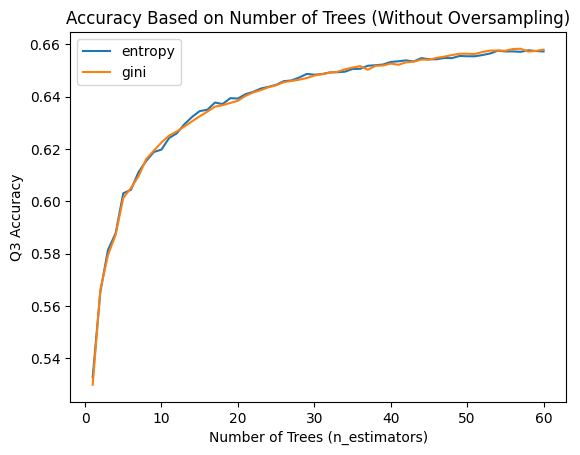

CPU times: user 9h 17min 18s, sys: 25.9 s, total: 9h 17min 44s
Wall time: 9h 18min 28s


In [12]:
%%time

# Without Oversampling

criteria = ["entropy", "gini"]

# Loop over the two criteria
for criterion_ in criteria:
    accuracy_data = []
    nums = []
    
    # Loop over every number of trees
    for i in range(1, 61):
        # Define model
        rf_model = MultiOutputClassifier(RandomForestClassifier(n_estimators = i, criterion = criterion_, random_state = randomer))
        # Fit training set to model
        rf_model.fit(X_train, y_train)
        # Use model to predict the validation set classes (elements)
        y_pred = rf_model.predict(X_val)
        # Calculate Q3 accuracy of prediction and append to 'accuracy_data'
        accuracy = q3_acc_numpy(y_val.flatten(), y_pred.flatten())
        accuracy_data.append(accuracy)
        nums.append(i)
    
    print(accuracy_data)
    
    plt.plot(nums, accuracy_data, label = criterion_)
    
plt.title("Accuracy Based on Number of Trees (Without Oversampling)")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Q3 Accuracy")
plt.legend()
plt.savefig("no_oversamp_rf.pdf")
plt.show()

### Set Hyperparameters

In [13]:
# Number of trees, criterion to measure split quality

num_estimators = 60
crit_ = "gini"

### Results of Chosen Model (Without Oversampling)

We train our final chosen model and test it on our test set. We also compare the results between training on the oversampled data against training on the original data.

In [14]:
%%time

# We determine that the following is a suitable model based on the above (without oversampling), using hyperparameters

# Original Data Model

rf_model1 = MultiOutputClassifier(RandomForestClassifier(n_estimators = num_estimators, criterion = crit_, random_state = randomer))
rf_model1.fit(X_train, y_train)
y_pred1 = rf_model1.predict(X_test)

CPU times: user 7min 45s, sys: 1.72 s, total: 7min 47s
Wall time: 7min 47s


===== Without Oversampling =====

Default Accuracy: 0.7764925373134328
Q3 Accuracy: 0.6518738758580186

               precision    recall  f1-score   support

     Padding   0.999803  0.999989  0.999896     91142
           C   0.637774  0.824154  0.719083     80377
           H   0.635853  0.573471  0.603053     53940
           E   0.858241  0.321815  0.468104     29141

    accuracy                       0.776493    254600
   macro avg   0.782918  0.679857  0.697534    254600
weighted avg   0.792201  0.776493  0.766300    254600



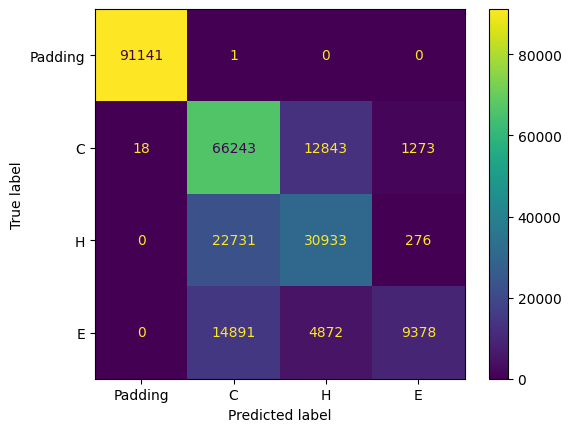

In [15]:
# Class labels as a dictionary, {0: "Padding", 1: "C", 2: "H", 3: "E"}

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

print("===== Without Oversampling =====\n")

# Output useful metrics

print(f"Default Accuracy: {accuracy_score(y_test.flatten(), y_pred1.flatten())}")
print(f"Q3 Accuracy: {q3_acc_numpy(y_test.flatten(), y_pred1.flatten())}")
print("\n", classification_report(y_test.flatten(), y_pred1.flatten(), target_names = ["Padding", "C", "H", "E"], digits = 6))

# Create and display confusion matrix

cm1 = confusion_matrix(y_test.flatten(), y_pred1.flatten())
disp1 = ConfusionMatrixDisplay(confusion_matrix = cm1, display_labels = ["Padding", "C", "H", "E"])
disp1.plot()
disp1.figure_.savefig("disp1.pdf")
plt.show()